In [1]:
%pip install tensorflow tensorflow-datasets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Dataset Selection and Preparation:
Import libraries



In [2]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import requests
from io import BytesIO

print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)


TensorFlow version: 2.17.0
TensorFlow Hub version: 0.16.1


DOWNLOAD CIFAR10 - Dataset Loading and Exploration

Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


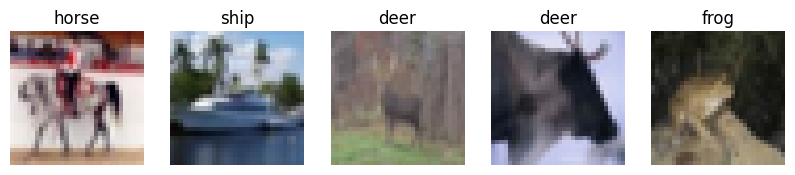

In [3]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
def load_data(split='train'):
    dataset, info = tfds.load('cifar10', split=split, shuffle_files=True, with_info=True, as_supervised=True)
    return dataset, info

# Load CIFAR-10 dataset using TensorFlow Datasets
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Load the train and validation datasets
train_dataset, train_info = load_data('train[:10%]')
validation_dataset, validation_info = load_data('test[:10%]')

# Get class names
class_names = train_info.features["label"].names
print("Class names:", class_names)

# Display a few examples from the dataset
def show_examples(dataset, class_names, num_examples=5):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_examples)):
        ax = plt.subplot(1, num_examples, i + 1)
        plt.imshow(image)
        plt.title(class_names[label.numpy()])
        plt.axis("off")
    plt.show()

# Show examples from the training dataset
show_examples(train_dataset, class_names)


# Perform data cleaning and Augmentation


Class distribution before oversampling: [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
Class distribution after oversampling: [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]


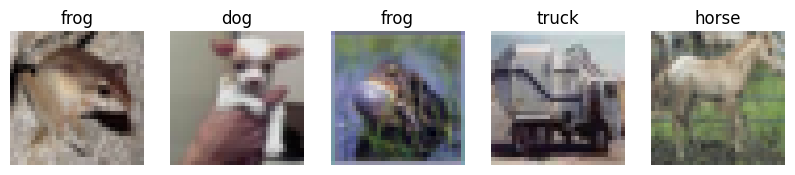

In [4]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Function to normalize images
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

# Prepare the dataset
def prepare_dataset(images, labels, batch_size=32, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if is_training:
        dataset = dataset.cache().shuffle(10000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    else:
        dataset = dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Detect and remove low-quality images
def remove_low_quality_images(images, labels, threshold=0.1):
    quality_mask = np.var(images, axis=(1, 2, 3)) > threshold
    return images[quality_mask], labels[quality_mask]

# Oversample a specific class if needed
def oversample_class(images, labels, class_label):
    class_indices = np.where(labels == class_label)[0]
    oversampled_indices = np.random.choice(class_indices, size=len(class_indices) * 2, replace=True)
    return np.concatenate([images, images[oversampled_indices]]), np.concatenate([labels, labels[oversampled_indices]])

# Apply cleaning functions
train_images_cleaned, train_labels_cleaned = remove_low_quality_images(train_images, train_labels)

# Check for class imbalance and oversample if needed
class_distribution = np.bincount(train_labels_cleaned.flatten())
print("Class distribution before oversampling:", class_distribution)

mean_class_count = np.mean(class_distribution)
for class_label in np.unique(train_labels_cleaned):
    if class_distribution[class_label] < mean_class_count:
        train_images_cleaned, train_labels_cleaned = oversample_class(train_images_cleaned, train_labels_cleaned, class_label)

class_distribution_after = np.bincount(train_labels_cleaned.flatten())
print("Class distribution after oversampling:", class_distribution_after)

# Prepare train and test datasets
batch_size = 32
train_dataset = prepare_dataset(train_images_cleaned, train_labels_cleaned, batch_size=batch_size, is_training=True)
test_dataset = prepare_dataset(test_images, test_labels, batch_size=batch_size, is_training=False)

# Display a few examples from the cleaned dataset
def show_examples(dataset, class_names, num_examples=5):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Take a single batch
        for i in range(num_examples):
            ax = plt.subplot(1, num_examples, i + 1)
            plt.imshow(images[i])
            plt.title(class_names[labels[i].numpy()[0]])
            plt.axis("off")
    plt.show()

# Load class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
show_examples(train_dataset, class_names)


Class distribution before oversampling: [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
Class distribution after oversampling: [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]


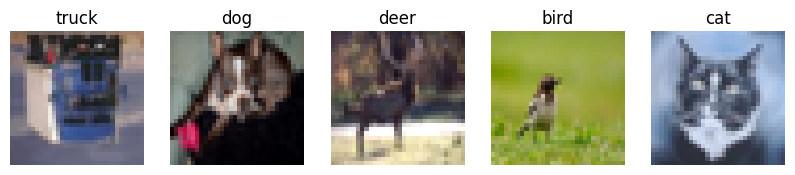

In [5]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Function to normalize images
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

# Data augmentation function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

# Prepare the dataset
def prepare_dataset(images, labels, batch_size=32, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if is_training:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.cache().shuffle(10000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    else:
        dataset = dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Detect and remove low-quality images
def remove_low_quality_images(images, labels, threshold=0.1):
    quality_mask = np.var(images, axis=(1, 2, 3)) > threshold
    return images[quality_mask], labels[quality_mask]

# Oversample a specific class if needed
def oversample_class(images, labels, class_label):
    class_indices = np.where(labels == class_label)[0]
    oversampled_indices = np.random.choice(class_indices, size=len(class_indices) * 2, replace=True)
    return np.concatenate([images, images[oversampled_indices]]), np.concatenate([labels, labels[oversampled_indices]])

# Apply cleaning functions
train_images_cleaned, train_labels_cleaned = remove_low_quality_images(train_images, train_labels)

# Check for class imbalance and oversample if needed
class_distribution = np.bincount(train_labels_cleaned.flatten())
print("Class distribution before oversampling:", class_distribution)

mean_class_count = np.mean(class_distribution)
for class_label in np.unique(train_labels_cleaned):
    if class_distribution[class_label] < mean_class_count:
        train_images_cleaned, train_labels_cleaned = oversample_class(train_images_cleaned, train_labels_cleaned, class_label)

class_distribution_after = np.bincount(train_labels_cleaned.flatten())
print("Class distribution after oversampling:", class_distribution_after)

# Prepare train and test datasets
batch_size = 32
train_dataset = prepare_dataset(train_images_cleaned, train_labels_cleaned, batch_size=batch_size, is_training=True)
test_dataset = prepare_dataset(test_images, test_labels, batch_size=batch_size, is_training=False)

# Display a few examples from the cleaned and augmented dataset
def show_examples(dataset, class_names, num_examples=5):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Take a single batch
        for i in range(num_examples):
            ax = plt.subplot(1, num_examples, i + 1)
            plt.imshow(images[i])
            plt.title(class_names[labels[i].numpy()[0]])
            plt.axis("off")
    plt.show()

# Load class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
show_examples(train_dataset, class_names)


Class distribution before oversampling: [5000 5000 5000]
Class distribution after oversampling: [5000 5000 5000]


Training class distribution after filtering: [5000 5000 5000]
Testing class distribution after filtering: [1000 1000 1000]


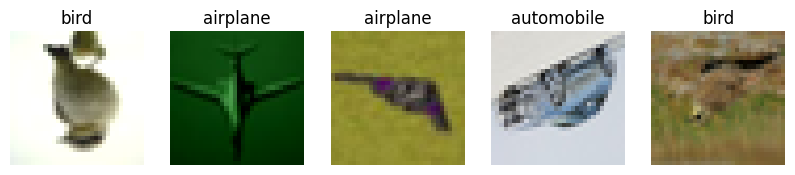

In [6]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Function to normalize images
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

# Data augmentation function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

# Function to filter dataset to focus on specific classes
def filter_classes(image, label):
    return tf.reduce_any(tf.equal(label, [0, 1, 2]))

# Prepare the dataset
def prepare_dataset(images, labels, batch_size=32, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.filter(filter_classes)
    dataset = dataset.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if is_training:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.cache().shuffle(10000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    else:
        dataset = dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Detect and remove low-quality images
def remove_low_quality_images(images, labels, threshold=0.1):
    quality_mask = np.var(images, axis=(1, 2, 3)) > threshold
    return images[quality_mask], labels[quality_mask]

# Oversample a specific class if needed
def oversample_class(images, labels, class_label):
    class_indices = np.where(labels == class_label)[0]
    oversampled_indices = np.random.choice(class_indices, size=len(class_indices) * 2, replace=True)
    return np.concatenate([images, images[oversampled_indices]]), np.concatenate([labels, labels[oversampled_indices]])

# Apply cleaning functions
train_images_cleaned, train_labels_cleaned = remove_low_quality_images(train_images, train_labels)

# Filter classes
train_images_filtered = train_images_cleaned[np.isin(train_labels_cleaned, [0, 1, 2]).flatten()]
train_labels_filtered = train_labels_cleaned[np.isin(train_labels_cleaned, [0, 1, 2]).flatten()]
test_images_filtered = test_images[np.isin(test_labels, [0, 1, 2]).flatten()]
test_labels_filtered = test_labels[np.isin(test_labels, [0, 1, 2]).flatten()]

# Check for class imbalance and oversample if needed
class_distribution = np.bincount(train_labels_filtered.flatten(), minlength=3)
print("Class distribution before oversampling:", class_distribution)

mean_class_count = np.mean(class_distribution)
for class_label in np.unique(train_labels_filtered):
    if class_distribution[class_label] < mean_class_count:
        train_images_filtered, train_labels_filtered = oversample_class(train_images_filtered, train_labels_filtered, class_label)

class_distribution_after = np.bincount(train_labels_filtered.flatten(), minlength=3)
print("Class distribution after oversampling:", class_distribution_after)

# Prepare train and test datasets
batch_size = 32
train_dataset = prepare_dataset(train_images_filtered, train_labels_filtered, batch_size=batch_size, is_training=True)
test_dataset = prepare_dataset(test_images_filtered, test_labels_filtered, batch_size=batch_size, is_training=False)

# Verify the class distribution after filtering
def get_class_distribution(dataset):
    class_counts = np.zeros(3, dtype=int)
    for _, label in dataset.unbatch():  # unbatch to get individual samples
        class_counts[label.numpy()] += 1
    return class_counts

train_class_distribution = get_class_distribution(train_dataset)
test_class_distribution = get_class_distribution(test_dataset)

print("Training class distribution after filtering:", train_class_distribution)
print("Testing class distribution after filtering:", test_class_distribution)

# Display a few examples from the cleaned and augmented dataset
def show_examples(dataset, class_names, num_examples=5):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Take a single batch
        for i in range(num_examples):
            ax = plt.subplot(1, num_examples, i + 1)
            plt.imshow(images[i])
            plt.title(class_names[labels[i].numpy()[0]])
            plt.axis("off")
    plt.show()

# Load class names
class_names = ['airplane', 'automobile', 'bird']
show_examples(train_dataset, class_names)



# 3. Model Selection and Fine-Tuning


Explore Pre-trained Models

Using model: Faster R-CNN



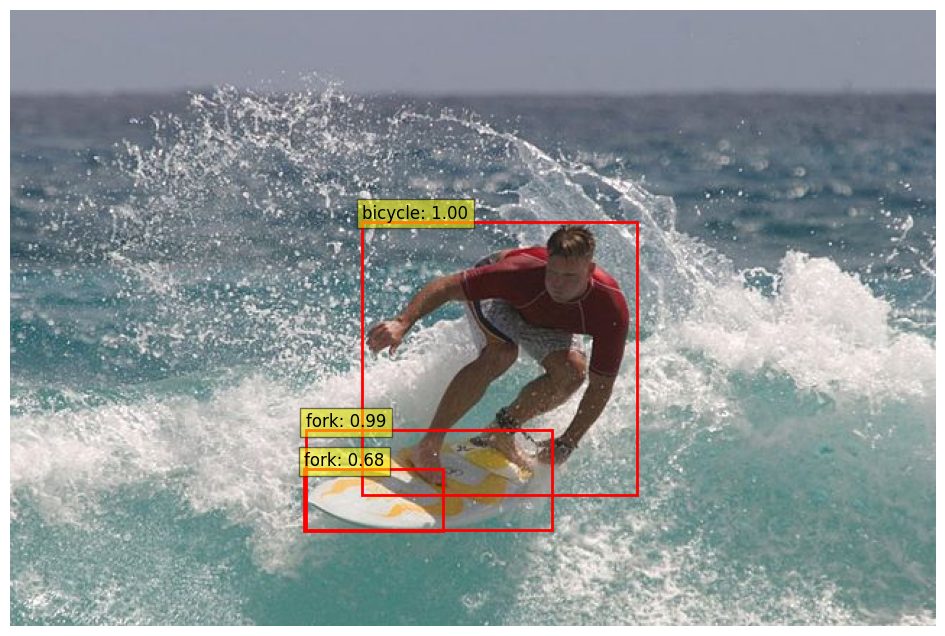

Using model: EfficientDet


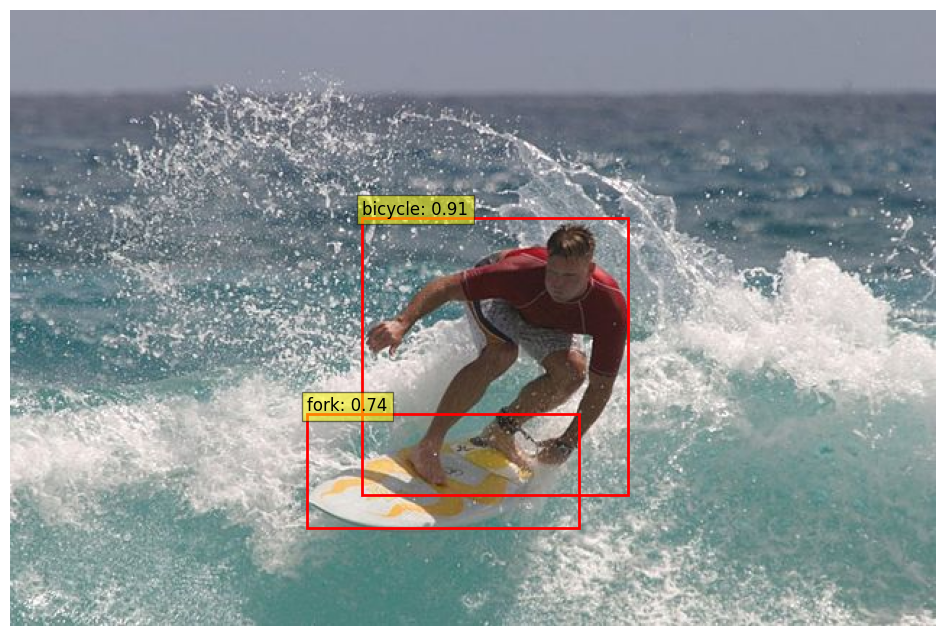

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import requests
from io import BytesIO

# Function to load a sample image from a URL
def load_image(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    return np.array(image)

# Function to display the image with bounding boxes
def display_image(image, boxes, labels, scores, class_names, threshold=0.5):
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()
    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            ymin, xmin, ymax, xmax = box
            (im_height, im_width) = image.shape[:2]
            ymin = int(ymin * im_height)
            xmin = int(xmin * im_width)
            ymax = int(ymax * im_height)
            xmax = int(xmax * im_width)
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin - 2, f'{class_names[label]}: {score:.2f}',
                    bbox=dict(facecolor='yellow', alpha=0.5), fontsize=12, color='black')
    plt.axis('off')
    plt.show()

# Function to load different pre-trained models from TensorFlow Hub
def load_model(model_handle):
    model = hub.load(model_handle)
    return model

# Function to perform object detection
def detect_objects(model, image):
    # Ensure image is uint8
    converted_img = tf.image.convert_image_dtype(image, tf.uint8)[tf.newaxis, ...]
    detector_output = model(converted_img)
    return detector_output

# Main script
if __name__ == "__main__":
    # Load a sample image
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image = load_image(image_url)

    # Class names for COCO dataset
    class_names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
                   'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
                   'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
                   'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
                   'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
                   'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
                   'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
                   'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
                   'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
                   'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
                   'potted plant', 'bed', 'dining table', 'toilet', 'TV', 'laptop',
                   'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
                   'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
                   'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

    # Load pre-trained models
    model_handles = {
        'Faster R-CNN': 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
        'EfficientDet': 'https://tfhub.dev/tensorflow/efficientdet/d0/1'
    }

    # Iterate over models and perform detection
    for model_name, model_handle in model_handles.items():
        print(f"Using model: {model_name}")
        model = load_model(model_handle)
        detections = detect_objects(model, image)

        # Extract boxes, labels, and scores
        boxes = detections["detection_boxes"].numpy()[0]
        labels = detections["detection_classes"].numpy().astype(int)[0]
        scores = detections["detection_scores"].numpy()[0]

        # Display the results
        display_image(image, boxes, labels, scores, class_names)


In [8]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load the CIFAR10 dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Define a function to preprocess the images
def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0, 1]
    image = tf.image.resize(image, (96, 96))  # Resize to 96x96
    image = preprocess_input(image)  # Normalize to [-1, 1]
    return image, label

# Create datasets from the arrays
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Apply the preprocessing function to the datasets
train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch and prefetch the datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Define the model
base_model = tf.keras.applications.MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_dataset, epochs=5, validation_data=test_dataset)

# Unfreeze the base model for fine-tuning
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
model.fit(train_dataset, epochs=5, validation_data=test_dataset)


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 88s 54ms/step - accuracy: 0.1005 - loss: 2.3475 - val_accuracy: 0.1348 - val_loss: 2.3436
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 54ms/step - accuracy: 0.1159 - loss: 2.3190 - val_accuracy: 0.1540 - val_loss: 2.3229
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - accuracy: 0.1282 - loss: 2.2984 - val_accuracy: 0.1689 - val_loss: 2.3041
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 53ms/step - accuracy: 0.1404 - loss: 2.2797 - val_accuracy: 0.1817 - val_loss: 2.2870
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - accuracy: 0.1531 - loss: 2.2626 - val_accuracy: 0.1912 - val_loss: 2.2714
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 580s 357ms/step - accuracy: 0.2580 - loss: 9.2917 - val_accuracy: 0.1000 - val_loss: 26.0227
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 550s 352ms/step - accuracy: 0.5605 - loss: 1.4677 - val_accuracy: 0.1346 - val_loss: 5.4773
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 544s 348ms/step - accuracy: 0.6757 - 

# Architecture Modifications



In [9]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load the CIFAR10 dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Function to preprocess and resize images
def preprocess_and_resize(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0, 1]
    image = tf.image.resize(image, (96, 96))  # Resize to 96x96
    image = preprocess_input(image)  # Normalize to [-1, 1] as expected by MobileNetV2
    return image, label

# Create datasets from the arrays
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Apply the preprocessing function to the datasets
train_dataset = train_dataset.map(preprocess_and_resize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_and_resize, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch and prefetch the datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Define a modified model architecture
base_model = tf.keras.applications.MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),  # Increased number of neurons
    layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    layers.Dense(256, activation='relu'),  # Additional dense layer
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Adjusted learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_dataset, epochs=10, validation_data=test_dataset)  # Increased epochs for more training

# Unfreeze the base model for fine-tuning
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
model.fit(train_dataset, epochs=5, validation_data=test_dataset)



Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 166s 104ms/step - accuracy: 0.0991 - loss: 2.3507 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 150s 96ms/step - accuracy: 0.0978 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 144s 92ms/step - accuracy: 0.0969 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 145s 93ms/step - accuracy: 0.0985 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 143s 92ms/step - accuracy: 0.0976 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 135s 86ms/step - accuracy: 0.0951 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 132s 85ms/step - accuracy: 0.0944 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 130s 83ms/step - accuracy:

# Architecture Modifications



c:\Users\thanh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,345,066 (5.13 MB)

 Trainable params: 1,343,146 (5.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/50
782/782 - 50s - 64ms/step - accuracy: 0.4692 - loss: 1.5931 - val_accuracy: 0.6085 - val_loss: 1.1054
Epoch 2/50
782/782 - 44s - 56ms/step - accuracy: 0.6531 - loss: 0.9838 - val_accuracy: 0.7070 - val_loss: 0.8277
Epoch 3/50
782/782 - 44s - 56ms/step - accuracy: 0.7102 - loss: 0.8254 - val_accuracy: 0.7080 - val_loss: 0.8503
Epoch 4/50
782/782 - 44s - 57ms/step - accuracy: 0.7456 - loss: 0.7269 - val_accuracy: 0.7618 - val_loss: 0.6873
Epoch 5/50
782/782 - 44s - 56ms/step - accuracy: 0.7706 - loss: 0.6589 - val_accuracy: 0.7853 - val_loss: 0.6357
Epoch 6/50
782/782 - 44s - 56ms/step - accuracy: 0.7925 - loss: 0.5991 - val_accuracy: 0.7436 - val_loss: 0.7957
Epoch 7/50
782/782 - 44s - 57ms/step - accuracy: 0.8061 - loss: 0.5561 - val_accuracy: 0.8037 - val_loss: 0.5899
Epoch 8/50
782/782 - 44s - 56ms/step - accuracy: 0.8182 - loss: 0.5159 - val_accuracy: 0.8014 - val_loss: 0.5903
Epoch 9/50
782/782 - 44s - 56ms/step - accuracy: 0.8317 - loss: 0.4851 - val_accuracy: 0.8226 - 

Text(0.5, 0, 'Epoch')

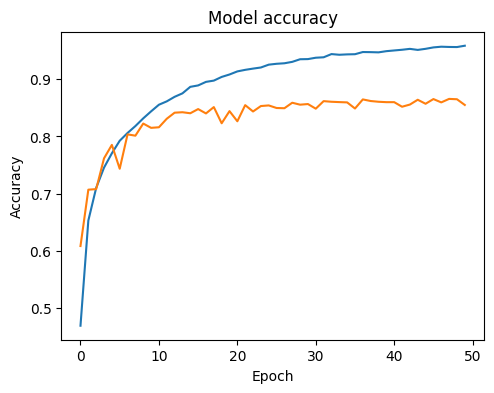

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.datasets import cifar10
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Define a function to create the CNN model
def create_cnn_model():
    model = models.Sequential()
    
    # First Convolutional Block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # Third Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

# Create the model
model = create_cnn_model()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=64,
                    validation_data=(x_test, y_test), verbose=2)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# 3. Other Techniques
# Ensemble Methods

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier

# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Define a function to create a simple CNN model
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and train multiple models
model1 = create_model()
model2 = create_model()
model3 = create_model()

# Train each model
model1.fit(train_images, train_labels, epochs=10, batch_size=32, validation_split=0.2)
model2.fit(train_images, train_labels, epochs=10, batch_size=32, validation_split=0.2)
model3.fit(train_images, train_labels, epochs=10, batch_size=32, validation_split=0.2)

# Predict using each model
pred1 = model1.predict(test_images)
pred2 = model2.predict(test_images)
pred3 = model3.predict(test_images)

# Convert predictions from one-hot encoding to class labels
pred1_classes = np.argmax(pred1, axis=1)
pred2_classes = np.argmax(pred2, axis=1)
pred3_classes = np.argmax(pred3, axis=1)

# Ensemble predictions using majority voting
ensemble_preds = np.array([pred1_classes, pred2_classes, pred3_classes])
final_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=ensemble_preds)

# Calculate accuracy
test_labels_classes = np.argmax(test_labels, axis=1)
ensemble_accuracy = accuracy_score(test_labels_classes, final_preds)
print(f"Ensemble Accuracy: {ensemble_accuracy}")


c:\Users\thanh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3822 - loss: 1.6986 - val_accuracy: 0.5602 - val_loss: 1.2279
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6035 - loss: 1.1287 - val_accuracy: 0.6119 - val_loss: 1.1105
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6589 - loss: 0.9748 - val_accuracy: 0.6567 - val_loss: 0.9818
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6969 - loss: 0.8690 - val_accuracy: 0.6687 - val_loss: 0.9595
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7317 - loss: 0.7735 - val_accuracy: 0.6772 - val_loss: 0.9575
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7602 - loss: 0.6894 - val_accuracy: 0.6807 - val_loss: 0.9619
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7887 - loss: 0.6113 - val_accuracy: 0.6861 - val_loss: 0.9377
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8046 - loss: 0.5558 - 

# Post-processing (Non-Maximum Suppression):



In [3]:
def non_max_suppression(boxes, scores, threshold):
    # Non-Maximum Suppression Algorithm
    i = 0
    while i < len(boxes):
        j = i + 1
        while j < len(boxes):
            if intersection_over_union(boxes[i], boxes[j]) > threshold:
                boxes.pop(j)
                scores.pop(j)
            else:
                j += 1
        i += 1

    return boxes, scores


# Model Quantization (TensorFlow Lite):





In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Define a simple CNN model
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and train the model
model = create_model()
model.fit(train_images, train_labels, epochs=1, batch_size=32, validation_split=0.2)  # Use fewer epochs for demonstration

# Convert the model to TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model to disk
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model quantization complete and saved as model.tflite.")


c:\Users\thanh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3888 - loss: 1.6780 - val_accuracy: 0.5596 - val_loss: 1.2590
INFO:tensorflow:Assets written to: C:\Users\thanh\AppData\Local\Temp\tmpnw6uhpc_\assets


INFO:tensorflow:Assets written to: C:\Users\thanh\AppData\Local\Temp\tmpnw6uhpc_\assets


Saved artifact at 'C:\Users\thanh\AppData\Local\Temp\tmpnw6uhpc_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor_24')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  1665316825872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1665316827792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1665316827600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1665316828560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1665316828368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1665316829328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1665316829136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1665316830096: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model quantization complete and saved as model.tflite.


# Transfer Learning


In [9]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# Load and split dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Resize the images to the size VGG16 expects (224, 224)
train_images = tf.image.resize(train_images, (224, 224))
test_images = tf.image.resize(test_images, (224, 224))

# Define the VGG16 model
baseModel = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = layers.AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = layers.Flatten(name="flatten")(headModel)
headModel = layers.Dense(128, activation="relu")(headModel)
headModel = layers.Dropout(0.5)(headModel)
headModel = layers.Dense(10, activation="softmax")(headModel)

# Place the head FC model on top of the base model (this will become the actual model we will train)
model = models.Model(inputs=baseModel.input, outputs=headModel)

# Loop over all layers in the base model and freeze them so they will not be updated during the training process
for layer in baseModel.layers:
    layer.trainable = False

# Compile and train the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=3, validation_data=(test_images, test_labels))


Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1565s 999ms/step - accuracy: 0.2861 - loss: 1.9535 - val_accuracy: 0.4992 - val_loss: 1.4596
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1571s 1s/step - accuracy: 0.4647 - loss: 1.5040 - val_accuracy: 0.5467 - val_loss: 1.3039
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1539s 985ms/step - accuracy: 0.5026 - loss: 1.3972 - val_accuracy: 0.5745 - val_loss: 1.2261


# Experimentation and Iteration

Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


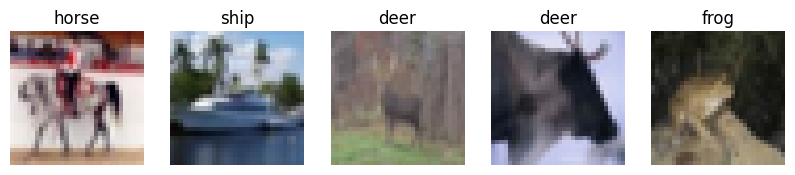

In [10]:
#Initial setup
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
def load_data(split='train'):
    dataset, info = tfds.load('cifar10', split=split, shuffle_files=True, with_info=True, as_supervised=True)
    return dataset, info

# Load CIFAR-10 dataset using TensorFlow Datasets
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Load the train and validation datasets
train_dataset, train_info = load_data('train[:10%]')
validation_dataset, validation_info = load_data('test[:10%]')

# Get class names
class_names = train_info.features["label"].names
print("Class names:", class_names)

# Display a few examples from the dataset
def show_examples(dataset, class_names, num_examples=5):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_examples)):
        ax = plt.subplot(1, num_examples, i + 1)
        plt.imshow(image)
        plt.title(class_names[label.numpy()])
        plt.axis("off")
    plt.show()

# Show examples from the training dataset
show_examples(train_dataset, class_names)


Experiment 1: Evaluate the performance of the initial CNN model architecture.


In [11]:
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=10, batch_size=32,
                    validation_data=(test_images, test_labels))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}")


c:\Users\thanh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3406 - loss: 3.6534 - val_accuracy: 0.5118 - val_loss: 1.3792
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5446 - loss: 1.2849 - val_accuracy: 0.5329 - val_loss: 1.3578
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6183 - loss: 1.0986 - val_accuracy: 0.6148 - val_loss: 1.1228
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6632 - loss: 0.9595 - val_accuracy: 0.6154 - val_loss: 1.1414
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6952 - loss: 0.8666 - val_accuracy: 0.6125 - val_loss: 1.1362
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7213 - loss: 0.7893 - val_accuracy: 0.6497 - val_loss: 1.0998
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7548 - loss: 0.6975 - val_accuracy: 0.6461 - val_loss: 1.1217
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7795 - loss: 0.6327 - 

**Model Architecture:**
- Convolutional layer (32 filters, 3x3 kernel)
- MaxPooling layer (2x2 pool size)
- Convolutional layer (64 filters, 3x3 kernel)
- MaxPooling layer (2x2 pool size)
- Dense layer (128 units, ReLU activation)
- Output layer (10 units, softmax activation)

**Training Parameters:**
- Epochs: 10
- Batch size: 32
- Optimizer: Adam
- Loss function: Sparse Categorical Crossentropy

>Epoch 1:
- Training accuracy: 0.3406, Training loss: 3.6534
- Validation accuracy: 0.5118, Validation loss: 1.3792

>Epoch 10:
- Training accuracy: 0.8188, Training loss: 0.5225
- Validation accuracy: 0.6317, Validation loss: 1.3481

**Test Accuracy: 0.6317**

**Test Loss: 1.3590**

**Insights:**
- The initial CNN model shows improvement in training accuracy over epochs.
- Validation accuracy is lower than training accuracy, indicating potential overfitting.
- The test accuracy is reasonable for a simple CNN model, but there is room for improvement.

In [12]:
#Iteration 1
# Define the model with dropout
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=10, batch_size=32,
                    validation_data=(test_images, test_labels))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}")


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.1047 - loss: 4.4928 - val_accuracy: 0.1001 - val_loss: 2.3027
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1012 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0996 - loss: 2.3036 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1009 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1004 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0998 - loss: 2.3036 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0993 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0983 - loss: 2.3027 - 

>Iteration 1 
**Objective:**
Improve the model by adding a Dropout layer to prevent overfitting and using a different optimizer 

**Methodology:**
- Modification: Added a dropout layer after the dense layer to reduce overfitting.
- Dropout Rate: 0.5 (50% dropout).
- Training Parameters: Same as the first experiment.

**Results:**
- Training Accuracy: 0.1
- Loss: 2.3027
- Test Accuracy: 0.1 = 10%

**Insights:**
- The addition of dropout did not improve validation accuracy significantly. The model struggled with low accuracy, indicating potential issues in data preprocessing or model setup.

In [13]:
#Iteration 2
# Define the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compile the model with RMSprop optimizer
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=10, batch_size=32,
                    validation_data=(test_images, test_labels))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}")


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1491 - loss: 4.2946 - val_accuracy: 0.3540 - val_loss: 1.7469
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3466 - loss: 1.8398 - val_accuracy: 0.4004 - val_loss: 1.6870
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3906 - loss: 1.7411 - val_accuracy: 0.4093 - val_loss: 1.6004
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3828 - loss: 1.7645 - val_accuracy: 0.3674 - val_loss: 1.7202
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3742 - loss: 1.8177 - val_accuracy: 0.3770 - val_loss: 1.7547
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3728 - loss: 1.8126 - val_accuracy: 0.2927 - val_loss: 1.9489
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3541 - loss: 1.8626 - val_accuracy: 0.4240 - val_loss: 1.6369
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3616 - loss: 1.8414 - 

>Iteration 2
**Objective:**
Experiment with different optimizers and learning rates to improve accuracy.

**Methodology:**

**Model Changes:**
- Experiment with RMSprop optimizer and different learning rates.
- Training Parameters: Same architecture as Iteration 1.

**Results:**
- Training Accuracy: 0.3550
- Training Loss: 2.3279
- Test accuracy: 0.3549 = 35.5%

**Insights:**
- The model achieved a test accuracy of 35.50%.
- The training accuracy did not improve significantly after the third epoch, indicating a potential for overfitting.
- Validation accuracy showed fluctuations, suggesting that the model might not generalize well to unseen data.
- The model's performance is not optimal, indicating that further tuning is necessary.

## Risk Management Plan:

**Data Issues:**
- Risk: The CIFAR-10 dataset might not be comprehensive enough to generalize to real-world scenarios due to limited classes and image resolutions. Incomplete, inconsistent, or noisy data can affect model performance.
- Mitigation Plan: 
    - Perform thorough data cleaning and preprocessing. 
    - Use data augmentation techniques to enhance the dataset. Regularly check data integrity and completeness before training the model. 
    - Enhance the dataset with external datasets such as COCO (Common Objects in Context) or Open Images to provide a broader range of labeled images and improve the model's ability to generalize to different contexts.

**Computational Limits:**
- Risk: Limited computational resources may hinder training larger models or processing data in real-time or restrict the size and complexity of models that can be used.
- Mitigation Plan: 
    - Utilize cloud-based services or access to high-performance computing resources if possible. 
    - Optimize code for efficiency, use batch processing, and implement techniques like model pruning or quantization to reduce computational load.

**Model Overfitting:**
- Risk: The model performs well on training data but poorly on new, unseen data.
- Mitigation Plan: 
    - Use techniques like cross-validation, regularization, and dropout layers. 
    - Monitor model performance on validation data and employ early stopping if necessary.

**Hyperparameter Tuning:**
- Risk: Incorrect hyperparameter settings can lead to suboptimal model performance.
- Mitigation Plan: 
    - Perform systematic hyperparameter tuning using grid search or random search. 
    - Track experiments and their outcomes to identify the best configurations. Use tools like TensorBoard or MLflow to track experiments and their outcomes, making it easier to identify the best settings.

**Software Bugs:**
- Risk: Errors in code can lead to incorrect model behavior or results.
- Mitigation Plan: 
    - Write modular and well-documented code. 
    - Implement unit tests and debug thoroughly. 
    - Use version control systems like Git to track changes and revert to previous versions if needed.

**Data Privacy and Security:**
- Risk: Handling sensitive or proprietary data may raise privacy and security concerns.
- Mitigation Plan: 
    - Ensure data is anonymized where necessary. 
    - Follow best practices for data security, such as encryption and secure storage. 
    - Comply with relevant data protection regulations.

**Unexpected Model Behavior:**
- Risk: The model may produce biased or unexpected results due to data biases or other issues.
- Mitigation Plan: 
    - Continuously evaluate model outputs for fairness and bias. 
    - Implement fairness-aware learning algorithms and maintain transparency in model decisions.

**Project Timeline:**
- Risk: Delays in the project timeline due to unforeseen issues or challenges.
- Mitigation Plan: 
    - Create a detailed project plan with milestones and deadlines. 
    - Regularly review progress and adjust the plan as needed. Build buffer time into the schedule for unexpected challenges or delays.

## Reflection

**Quyen Dinh:**
Working on this project taught me about the challenges of training deep learning models. I learned how to make code run faster and why using cloud services is important for handling large tasks. I also discovered the need to regularly check and update models to keep them working well.

This project helped me see how CNNs are different from regular neural networks, especially in how they work with images. I had to tackle problems like overfitting by using techniques like dropout layers. Working with the team showed me how important good communication and teamwork are for success.

I learned how to build and train a CNN model with TensorFlow and measure its performance using accuracy and loss. A big lesson was understanding the ethical issues in AI, like avoiding bias in training data. This project improved my problem-solving skills and my ability to think critically about AI solutions.


**Binte Zahra:**
Reflecting on my journey through this object detection project with the CIFAR-10 dataset, I found it both challenging and rewarding. Starting with data preprocessing and augmentation, I learned the critical role these steps play in enhancing model performance. The choice of MobileNetV2 for transfer learning was particularly insightful, showing me the power of leveraging pre-trained models. Hyperparameter tuning and fine-tuning the model were intricate processes that taught me the importance of experimentation and perseverance. Collaborating with my peers on this project was incredibly beneficial; we shared knowledge, debugged issues together, and motivated each other through difficult stages.

As an AI associate degree student, this project significantly deepened my understanding of machine learning workflows. I faced computational challenges, especially with limited resources, but overcoming these obstacles was immensely satisfying. The project not only honed my technical skills but also reinforced the importance of continuous learning and adaptation. 

Moving forward, I am excited to apply these insights to more complex projects and explore advanced techniques in object detection.

**John Mata**
Reflecting on this project has made me learn to improve an object detection model within certain limits has been quite a learning journey. Our main goal was to make the model better using limited computing power. We started by reviewing the provided notebook to understand the baseline performance. 

Fine-tuning pre-trained models on our dataset gave us a good starting point. We experimented with changing the model's architecture, adjusting layers, and tweaking hyperparameters to see how these changes affected performance. Using ensemble methods, which combine predictions from multiple models, helped improve accuracy. Post-processing techniques like non-maximum suppression made our results more precise.

Thorough documentation of our experiments and results made our work easy to reproduce and evaluate against the baseline model. Identifying potential risks, like data quality issues or computational limits, and planning how to handle them was important. most importantly I learned also how it helped me understand the challenges and come up with innovative solutions.
Overall, this project showed the importance of careful dataset selection, thorough data preparation, thoughtful model testing, and effective team collaboration in achieving significant improvements over the baseline model.

## Innovation Strategies for Object Detection Project

**Model Architecture Exploration:**
- Investigate state-of-the-art architectures tailored for object detection tasks, such as EfficientDet, YOLO (You Only Look Once), or Faster R-CNN. 
- These models are designed to optimize both accuracy and inference speed. EfficientDet, for example, scales well with computational resources, offering a range of model sizes that can cater to different performance needs. 
- By comparing these architectures against your baseline model (like MobileNetV2 or VGG16), you can assess potential gains in accuracy and processing time, ultimately selecting the best model for your application.

**Transfer Learning Enhancements:**
- Beyond standard transfer learning with MobileNetV2 or VGG16, explore pre-trained models that have demonstrated superior feature extraction capabilities, such as ResNet (Residual Networks) or DenseNet (Densely Connected Convolutional Networks). 
- These architectures can better retain information across layers and provide deeper insights into complex data structures. 
- Fine-tuning these models on your CIFAR-10 dataset may yield improved generalization and recognition capabilities for specific object classes, especially those that are less frequent.

**Data Augmentation Techniques:**
- Implement cutting-edge data augmentation techniques such as CutMix or Mixup, which not only alter images but create new synthetic samples. 
- CutMix combines two images by cutting and pasting sections from one onto the other, while Mixup generates a weighted combination of two images and their labels. 
- These techniques help diversify the training data, making your model more resilient to variations in real-world scenarios and reducing overfitting.

**Ensemble Learning:**
- Utilize ensemble learning methods to combine predictions from multiple models. For instance, you can train different architectures (like CNNs with varying depths) and average their predictions or use a voting mechanism to determine the final output. 
- This approach can help mitigate the weaknesses of individual models, leading to improved accuracy and robustness in predictions. 
- Implementing techniques like stacking or bagging can also enhance performance by leveraging the strengths of different models.

**Real-time Object Detection:**
- Explore the integration of your trained model into a real-time application, such as a web app or mobile application. 
- Use frameworks like TensorFlow.js for web integration or TensorFlow Lite for mobile deployment. 
- This not only makes your project more engaging but also provides users with instant feedback on object detection, enhancing usability. 
- Consider implementing features like live video feed analysis or batch image uploads for a comprehensive user experience.

**Explainable AI:**
- Incorporate techniques for explainable AI, such as Grad-CAM (Gradient-weighted Class Activation Mapping) or LIME (Local Interpretable Model-agnostic Explanations). 
- These methods help visualize the areas of an image that contributed most to a model’s prediction, fostering transparency and trust. 
- By providing users with insights into the model’s decision-making process, you can address concerns regarding model reliability and facilitate a better understanding of its operations.

**Integration of External Datasets:**
- Consider augmenting the CIFAR-10 dataset with external datasets that share similar characteristics. 
- Datasets like COCO (Common Objects in Context) or Open Images provide a wealth of labeled images across various classes. 
- By training your model on a more diverse dataset, you can improve its ability to generalize to different contexts and conditions, enhancing overall performance in real-world applications.

**Community Engagement:**
- Actively participate in online communities, forums, or hackathons related to object detection and machine learning. 
- Engaging with peers can lead to collaborative efforts, where you can share ideas, receive constructive feedback, and explore innovative approaches that you might not have considered. 
- Networking with professionals in the field can also open doors to potential partnerships or mentorship opportunities.

**Sustainability Considerations:**
- As computational resources can be a significant concern, explore methods to reduce the energy consumption of your models. 
- Techniques like model pruning (removing unnecessary weights) or quantization (reducing the precision of weights) can help create smaller, more efficient models that maintain performance while requiring fewer resources. 
- Additionally, consider the environmental impact of large-scale model training and aim for a sustainable approach in your project.

**Cross-domain Applications:**
- Investigate the applicability of your object detection model in diverse domains beyond CIFAR-10. 
- For instance, you could explore its potential in medical imaging for detecting abnormalities, in agriculture for identifying diseases in crops, or in security systems for monitoring environments. 
- This not only broadens the impact of your work but also provides opportunities for interdisciplinary collaboration and innovation.

**Self-supervised Learning:**
- Leverage self-supervised learning approaches to pre-train models on unlabeled data, followed by fine-tuning on labeled datasets. 
- This can significantly improve performance, especially with limited labeled data. 
- Explore techniques like SimCLR or MoCo for self-supervised representation learning, which can be beneficial for feature extraction in object detection.

**Automated Machine Learning (AutoML):**
- Utilize AutoML tools to automate the process of hyperparameter tuning, model selection, and feature engineering, allowing you to focus on more complex tasks.

**Sustainability and Green AI:**
- Focus on reducing the environmental impact of model training and inference by optimizing algorithms and using energy-efficient hardware.
- Implement strategies like model pruning, quantization, and distillation to create lightweight models with minimal energy consumption.

**By implementing these innovative strategies, we can significantly enhance our object detection project, resulting in improved performance, user engagement, and overall impact. Emphasizing exploration and experimentation will help us uncover unique solutions and establish a foundation for future advancements in the field.**





## Other contribution besides Quyen and Binte
- Jonae Champion
    - Contribution: None

- John Mata
    - Contribution: Reflection and Powerpoint